In [1]:
import requests
import pandas as pd

client_id = 'Q7BQZZieVNOOl1yEhNYQhUpYGLaAjptGFnp49sABJlZacqPRB9' #api key
client_secret = 'NoKbh30itBqaJFx3vEZoLf8DWacWQtCWPfrD6zoa'
auth_url = 'https://api.petfinder.com/v2/oauth2/token'
auth_data = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret
}

response = requests.post(auth_url, data=auth_data)
token = response.json().get('access_token')


In [2]:
headers = {
    'Authorization': f'Bearer {token}'
}
params = {
    'location': '84606',
    'distance': 100,
    'limit': 50           
}

# Fetch multiple pages
all_animals = []
page = 1
max_pages = 8

while page <= max_pages:
    params['page'] = page
    response = requests.get('https://api.petfinder.com/v2/animals', headers=headers, params=params)

    if response.status_code == 200:
        animals_data = response.json()['animals']
        
        if not animals_data:
            break

        for animal in animals_data:
            record = {
                'organization_id': animal.get('organization_id'),
                'id': animal.get('id'),
                'species': animal.get('species'),
                'name': animal.get('name'),
                'age': animal.get('age'),
                'breed': animal.get('breeds', {}).get('primary'),
                'mixed': animal.get('breeds', {}).get('mixed'),
                'color': animal.get('colors', {}).get('primary'),
                'fixed': animal.get('attributes', {}).get('spayed_neutered'),
                'house_trained': animal.get('attributes', {}).get('house_trained'),
                'good_with_children': animal.get('environment', {}).get('children'),
                'good_with_dogs': animal.get('environment', {}).get('dogs'),
                'good_with_cats': animal.get('environment', {}).get('cats'),
                'gender': animal.get('gender'),
                'distance': animal.get('distance')                
            }
            all_animals.append(record)
        
        page += 1 
    else:
        print("Error:", response.status_code, response.json())
        break

animals_df = pd.DataFrame(all_animals)
print(animals_df)


    organization_id        id species           name    age  \
0              UT07  73941082     Cat        Othello   Baby   
1              UT07  73941081     Cat          Betsy   Baby   
2              UT07  73941084     Cat       Cordelia   Baby   
3              UT07  73941085     Cat           Rico   Baby   
4              UT07  73941083     Cat     *Squirrel*  Adult   
..              ...       ...     ...            ...    ...   
395            UT07  73865812     Cat      *Legolas*  Adult   
396            UT07  73865807     Cat  *Razzleberry*  Adult   
397            UT07  73865795     Cat        *Chive*  Adult   
398            UT07  73865811     Cat         *Fugi*  Adult   
399            UT07  73865810     Cat       *Pippin*   Baby   

                    breed  mixed color  fixed  house_trained  \
0     Domestic Short Hair   True  None   True          False   
1      Domestic Long Hair   True  None   True          False   
2     Domestic Short Hair   True  None   True      

In [ ]:
# Need organization names
org_ids = animals_df['organization_id'].unique()
org_names = {}

for id in org_ids:
    org_response = requests.get(f'https://api.petfinder.com/v2/organizations/{id}', headers=headers)
    if org_response.status_code == 200:
        org_data = org_response.json().get('organization', {})
        org_names[id] = org_data.get('name')
    else:
        print(f"Error fetching organization {id}")


Error fetching organization UT140


In [ ]:
animals_df['organization_name'] = animals_df['organization_id'].map(org_names)
animals_df['organization_name'].unique()

array(['Salt Lake County Animal Services',
       'Utah Valley Animal Rescue, Inc.', 'Nuzzles & Co. Adoption Center',
       'Celestial Zoo Pet Rescue', 'Rescue Rovers Dog Adoptions',
       'Wasatch Wanderers', 'Roosevelt Animal Shelter',
       'Furever Friends Animal Oasis', 'Desiderata Rescue',
       'The Golden Bark Foundation',
       'Community Animal Welfare Society (CAWS)', 'Herding Haven',
       'Davis County Animal Services', 'Humane Society of Utah',
       'Humane Society of Northern Utah', 'Throw a Dog a Bone Dog Rescue',
       'Kitty CrusAIDe', 'Hearts 4 Paws',
       'Utah Animal Advocacy Foundation', 'Outreach Pawsabilities',
       'Best Friends Animal Society-Utah', 'Pet Samaritan Fund',
       'Happy Tails at Pegasus', 'Jason Heigl Foundation',
       'Utah Animal Adoption Center', 'Carbon Cat Rescue',
       'Ruff Patch Rescue', 'Castle Valley Animal Rescue',
       'Mountain Mama Pyrs and Pups', nan, 'Beaumont Pets Alive',
       'Friends of Community-Cats Resc

In [5]:
animals_df.shape

(400, 16)

In [6]:
animals_df.dtypes

organization_id        object
id                      int64
species                object
name                   object
age                    object
breed                  object
mixed                    bool
color                  object
fixed                    bool
house_trained            bool
good_with_children     object
good_with_dogs         object
good_with_cats         object
gender                 object
distance              float64
organization_name      object
dtype: object

In [7]:
animals_df.columns

Index(['organization_id', 'id', 'species', 'name', 'age', 'breed', 'mixed',
       'color', 'fixed', 'house_trained', 'good_with_children',
       'good_with_dogs', 'good_with_cats', 'gender', 'distance',
       'organization_name'],
      dtype='object')

In [ ]:
# summary statistics
summary_stats = {
    'Total Animals': len(animals_df),
    'Species Distribution': animals_df['species'].value_counts(),
    'Age Groups': animals_df['age'].value_counts(),
    'Most Common Breeds': animals_df['breed'].value_counts().head(),
    'Gender Distribution': animals_df['gender'].value_counts(normalize=True),
    'Percentage of Animals Fixed': (animals_df['fixed'] == True).mean() * 100,
    'House Trained Percentage': (animals_df['house_trained'] == True).mean() * 100,
    'Most Common Colors': animals_df['color'].value_counts().head(),
    'Organizations Count': animals_df['organization_name'].nunique()
}

print(summary_stats)

{'Total Animals': 370, 'Species Distribution': species
Cat        215
Dog        149
Rat          2
Rabbit       2
Duck         1
Chicken      1
Name: count, dtype: int64, 'Average Age': age
Baby      131
Adult     118
Young      98
Senior     23
Name: count, dtype: int64, 'Most Common Breeds': breed
Domestic Short Hair     156
Domestic Medium Hair     30
Domestic Long Hair       22
Mixed Breed              20
Chihuahua                14
Name: count, dtype: int64, 'Gender Distribution': gender
Male      0.516216
Female    0.483784
Name: proportion, dtype: float64, 'Fixed Percentage': 78.37837837837837, 'House Trained Percentage': 25.405405405405407, 'Most Common Colors': color
Black                               64
Brown / Chocolate                   41
Gray / Blue / Silver                38
Orange / Red                        20
Tricolor (Brown, Black, & White)    16
Name: count, dtype: int64, 'Organizations Count': 27}


In [ ]:
#EDA



In [10]:
test_df = animals_df.dropna(subset=['good_with_dogs', 'good_with_cats', 'good_with_children']) 

In [11]:
def plot_pet_compatibility(df):
    # Calculate the proportions
    proportions = {
        'Good with Dogs': (df['good_with_dogs'] == True).mean() * 100,
        'Good with Cats': (df['good_with_cats'] == True).mean() * 100,
        'Good with Children': (df['good_with_children'] == True).mean() * 100
    }
    
    plt.figure()

    bars = plt.bar(proportions.keys(), proportions.values(), color = 'purple')
    
    # Customize the plot
    plt.title('Pet Compatibility Analysis', fontsize=14, pad=20)
    plt.ylabel('Percentage of Pets (%)', fontsize=12)
    
    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    # Set y-axis to go from 0 to 100
    plt.ylim(0, 100)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)
    return plt

# Example usage:
# Assuming your dataframe is called 'df'
plot_pet_compatibility(test_df)
plt.show()

NameError: name 'plt' is not defined

Text(0, 0.5, 'Count of Animals')

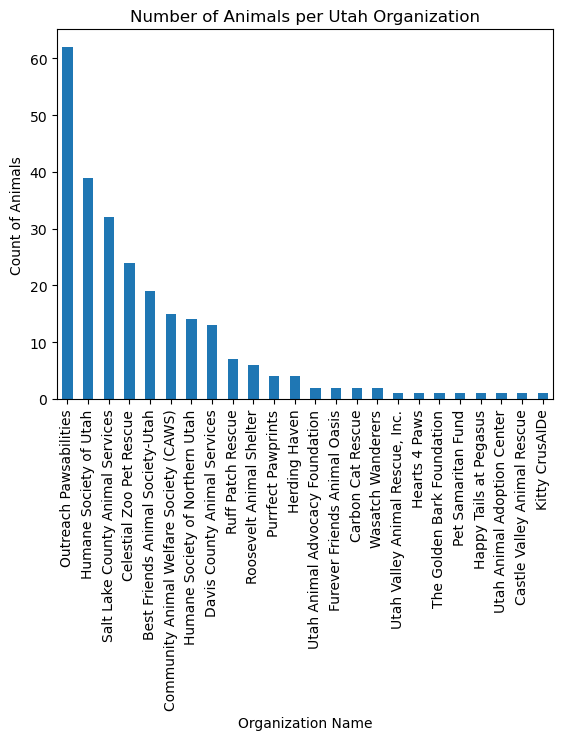

In [ ]:
#EDA
import matplotlib.pyplot as plt

count_by_org = animals_df['organization_name'].value_counts()
count_by_org.plot(kind = 'bar')
plt.title("Number of Animals per Utah Organization")
plt.xlabel('Organization Name')
plt.ylabel("Count of Animals")


In [ ]:
# Question of Interest
# Which pet organization near me has a higher proportion of cats in shelter than dogs?

